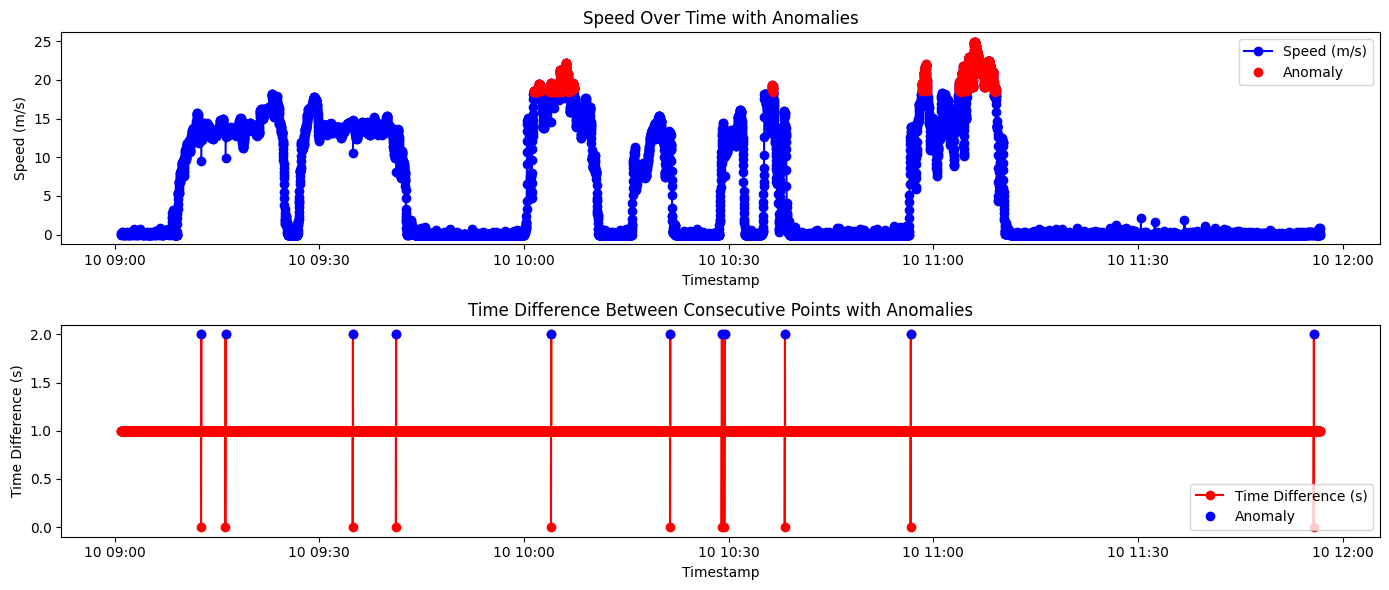

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the sample CSV file
file_path = 'nmea.csv'  # Replace with the path to your file
data_sample = pd.read_csv(file_path)

# Clean column names
data_sample.columns = data_sample.columns.str.strip()

# Convert timestamp column to datetime format for time-based calculations
data_sample['timestamp'] = pd.to_datetime(data_sample['timestamp'])

# Calculate time differences between consecutive points
data_sample['time_diff'] = data_sample['timestamp'].diff().dt.total_seconds()

# Define a helper function to calculate the haversine distance in meters between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Calculate distance between consecutive points
data_sample['distance'] = data_sample.apply(
    lambda row: haversine(row['lat'], row['lon'], row['lat'], row['lon']) 
    if row.name == 0 else haversine(
        data_sample.at[row.name - 1, 'lat'],
        data_sample.at[row.name - 1, 'lon'],
        row['lat'], row['lon']), axis=1)

# Calculate speed (distance over time)
data_sample['speed'] = data_sample['distance'] / data_sample['time_diff']

# Setting thresholds for anomalies
speed_threshold = data_sample['speed'].quantile(0.95)  # Top 5% threshold for speed
time_diff_threshold = data_sample['time_diff'].quantile(0.95)  # Top 5% threshold for time difference

# Identifying anomalies based on thresholds
data_sample['speed_anomaly'] = data_sample['speed'] > speed_threshold
data_sample['time_diff_anomaly'] = data_sample['time_diff'] > time_diff_threshold

# Plotting speed and time difference with anomalies
plt.figure(figsize=(14, 6))

# Speed plot with anomalies
plt.subplot(2, 1, 1)
plt.plot(data_sample['timestamp'], data_sample['speed'], marker='o', linestyle='-', color='b', label="Speed (m/s)")
plt.plot(data_sample[data_sample['speed_anomaly']]['timestamp'], 
         data_sample[data_sample['speed_anomaly']]['speed'], 'ro', label="Anomaly")
plt.title("Speed Over Time with Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Speed (m/s)")
plt.legend()

# Time difference plot with anomalies
plt.subplot(2, 1, 2)
plt.plot(data_sample['timestamp'], data_sample['time_diff'], marker='o', linestyle='-', color='r', label="Time Difference (s)")
plt.plot(data_sample[data_sample['time_diff_anomaly']]['timestamp'], 
         data_sample[data_sample['time_diff_anomaly']]['time_diff'], 'bo', label="Anomaly")
plt.title("Time Difference Between Consecutive Points with Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Time Difference (s)")
plt.legend()

plt.tight_layout()
plt.show()



In [2]:
import pandas as pd
import numpy as np
import math

# Load your dataset (replace 'nmea.csv' with the actual filename)
data_sample = pd.read_csv('nmea.csv')  # Update filename as necessary

# Clean column names (in case they have leading or trailing spaces)
data_sample.columns = data_sample.columns.str.strip()

# Define the column names for latitude, longitude, and timestamp
lat_column = 'lat'  # Replace with actual column name if different
lon_column = 'lon'  # Replace with actual column name if different
timestamp_column = 'timestamp'  # Replace with actual column name if different

# Convert timestamp to datetime if it's not already
if timestamp_column in data_sample.columns:
    data_sample[timestamp_column] = pd.to_datetime(data_sample[timestamp_column], errors='coerce')

# Drop rows where timestamp could not be converted (invalid dates)
data_sample.dropna(subset=[timestamp_column], inplace=True)

# Calculate 'speed', 'time_diff', and 'direction_change' if they don't exist
if 'speed' not in data_sample.columns and lat_column in data_sample.columns and lon_column in data_sample.columns:
    # Calculate speed (using a simple difference formula)
    data_sample['speed'] = (
        np.sqrt(data_sample[lat_column].diff()**2 + data_sample[lon_column].diff()**2)
        / data_sample[timestamp_column].diff().dt.total_seconds().replace(0, np.nan)
    ).fillna(0)

# Calculate time difference if not already present
if 'time_diff' not in data_sample.columns:
    data_sample['time_diff'] = data_sample[timestamp_column].diff().dt.total_seconds().fillna(1)

# Calculate direction change if not already present
if 'direction_change' not in data_sample.columns and lat_column in data_sample.columns and lon_column in data_sample.columns:
    data_sample['direction_change'] = np.arctan2(data_sample[lat_column].diff(), data_sample[lon_column].diff()).fillna(0)

# Now define the features dataframe
features = data_sample[['speed', 'time_diff', 'direction_change']].copy()

# Ensure all columns are numeric for analysis
features = features.apply(pd.to_numeric, errors='coerce')

# Check for NaN values
print("NaN values in features:\n", features.isna().sum())

# Check for infinity values and replace them with NaN
features.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Any infinite values in features:\n", features.isin([np.inf, -np.inf]).sum())

# Replace NaN values with column means to ensure data integrity for analysis
features.fillna(features.mean(), inplace=True)

# Check for extremely large values
print("Max values in features:\n", features.max())


NaN values in features:
 speed               0
time_diff           0
direction_change    0
dtype: int64
Any infinite values in features:
 speed               0
time_diff           0
direction_change    0
dtype: int64
Max values in features:
 speed               0.000561
time_diff           2.000000
direction_change    3.141593
dtype: float64


Any infinite values in features after cleaning:
 speed               0
time_diff           0
direction_change    0
dtype: int64
Max values in features after capping:
 speed               0.000456
time_diff           1.000000
direction_change    3.141593
dtype: float64


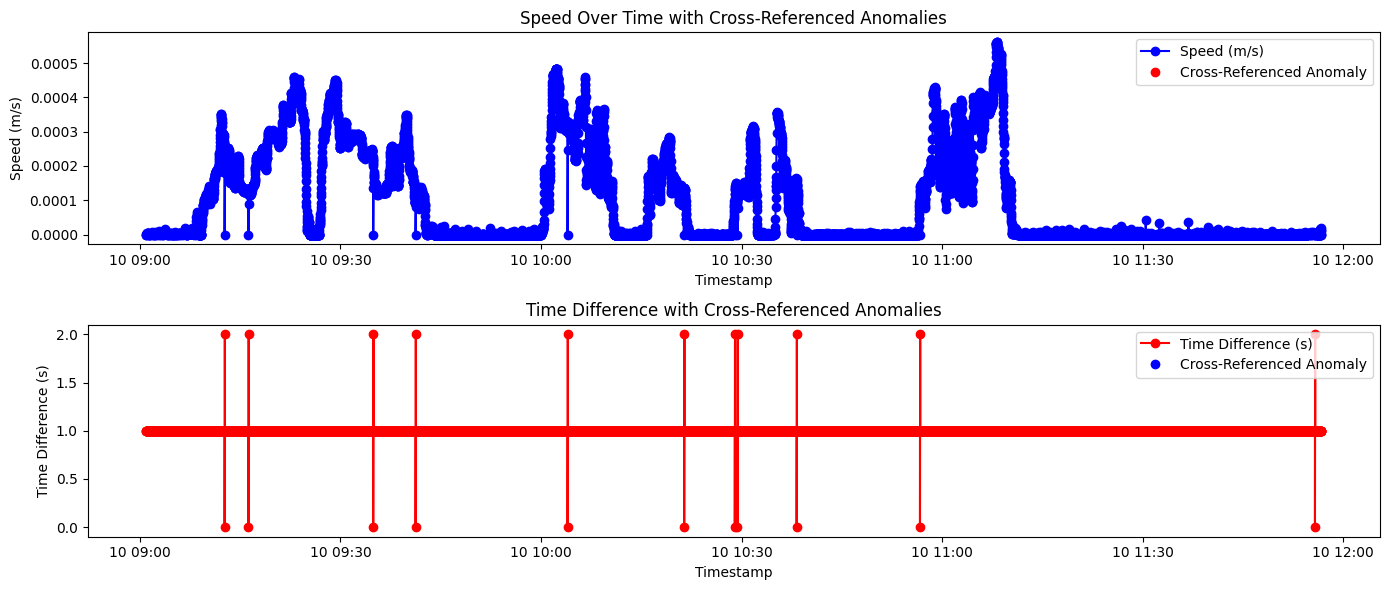

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assuming 'data_sample' already exists and contains features like 'speed' and 'time_diff'

# Step 1: Replace any remaining infinite values with NaN, then replace NaN with column max
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.fillna(features.max(), inplace=True)

# Step 2: Cap any remaining very large values to ensure they fall within a reasonable range
# Here, we cap any values above the 99th percentile to avoid extreme outliers
for column in features.columns:
    max_cap = features[column].quantile(0.99)
    features[column] = np.clip(features[column], a_min=None, a_max=max_cap)

# Step 3: Verify that there are no remaining infinite or extremely large values
print("Any infinite values in features after cleaning:\n", np.isinf(features).sum())
print("Max values in features after capping:\n", features.max())

# Step 4: Standardize the features after cleaning
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Proceed with DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
clusters = dbscan.fit_predict(features_scaled)

# Add the cluster labels to your DataFrame for analysis
data_sample['cluster'] = clusters

# Mark anomalies (where cluster == -1 in DBSCAN)
data_sample['cluster_anomaly'] = data_sample['cluster'] == -1

# Step 5: Define speed and time difference anomalies based on a threshold (e.g., values above the 99th percentile)
speed_threshold = data_sample['speed'].quantile(0.99)
time_diff_threshold = data_sample['time_diff'].quantile(0.99)

data_sample['speed_anomaly'] = data_sample['speed'] > speed_threshold
data_sample['time_diff_anomaly'] = data_sample['time_diff'] > time_diff_threshold

# Step 6: Cross-reference anomalies (speed and time difference anomalies happening together)
data_sample['cross_referenced_anomaly'] = (
    data_sample['speed_anomaly'] & data_sample['time_diff_anomaly'] & data_sample['cluster_anomaly']
)

# Plot results to visualize cross-referenced anomalies
plt.figure(figsize=(14, 6))

# Speed plot with cross-referenced anomalies
plt.subplot(2, 1, 1)
plt.plot(data_sample['timestamp'], data_sample['speed'], marker='o', linestyle='-', color='b', label="Speed (m/s)")
plt.plot(data_sample[data_sample['cross_referenced_anomaly']]['timestamp'], 
         data_sample[data_sample['cross_referenced_anomaly']]['speed'], 'ro', label="Cross-Referenced Anomaly")
plt.title("Speed Over Time with Cross-Referenced Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Speed (m/s)")
plt.legend()

# Time difference plot with cross-referenced anomalies
plt.subplot(2, 1, 2)
plt.plot(data_sample['timestamp'], data_sample['time_diff'], marker='o', linestyle='-', color='r', label="Time Difference (s)")
plt.plot(data_sample[data_sample['cross_referenced_anomaly']]['timestamp'], 
         data_sample[data_sample['cross_referenced_anomaly']]['time_diff'], 'bo', label="Cross-Referenced Anomaly")
plt.title("Time Difference with Cross-Referenced Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Time Difference (s)")
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
from sklearn.cluster import DBSCAN
import pandas as pd

eps_value = 0.5  # Increase this value to allow larger clusters
min_samples_value = 1  # Decrease this value to allow smaller clusters

# Apply DBSCAN with adjusted parameters
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(features_scaled)
data_sample['cluster'] = clusters

# Mark anomalies with more lenient criteria
data_sample['cluster_anomaly'] = data_sample['cluster'] == -1

# Simplify cross-referenced anomalies for testing
data_sample['cross_referenced_anomaly'] = (
    data_sample['speed_anomaly'] | data_sample['time_diff_anomaly']
)

# Save anomalies again
anomalies = data_sample[data_sample['cross_referenced_anomaly']]
anomalies.to_csv("cross_referenced_anomalies.csv", index=False)

print("Anomalies saved to 'cross_referenced_anomalies.csv' with adjusted criteria.")



Anomalies saved to 'cross_referenced_anomalies.csv' with adjusted criteria.


Statistical Summary of Anomalies:
            speed   time_diff
count  117.000000  117.000000
mean     0.000462    1.094017
std      0.000120    0.293108
min      0.000002    1.000000
25%      0.000460    1.000000
50%      0.000482    1.000000
75%      0.000524    1.000000
max      0.000561    2.000000


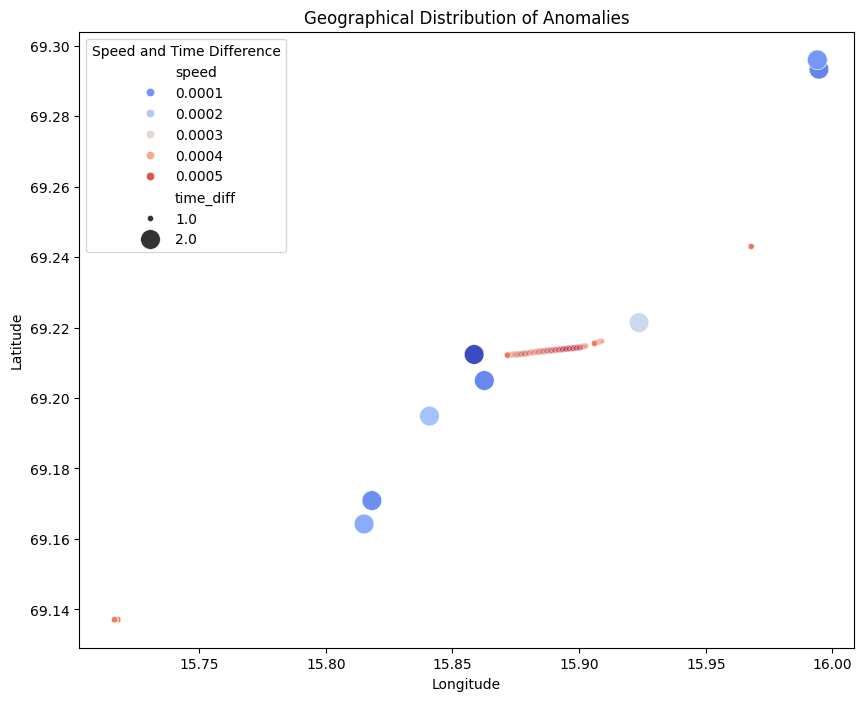

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the anomalies CSV file
anomalies = pd.read_csv("cross_referenced_anomalies.csv")

# Step 1: Statistical Summary with NaN and Infinite Check
anomalies = anomalies.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
summary_stats = anomalies[['speed', 'time_diff']].dropna().describe()  # Drop NaNs for summary
print("Statistical Summary of Anomalies:")
print(summary_stats)

# Step 2: Check for valid latitude, longitude, speed, and time_diff data before plotting
if 'lat' in anomalies.columns and 'lon' in anomalies.columns:
    # Drop NaN values and filter out zero coordinates
    valid_data = anomalies[['lat', 'lon', 'speed', 'time_diff']].dropna()  # Drop rows with NaN values
    valid_data = valid_data[(valid_data['lat'] != 0) & (valid_data['lon'] != 0)]  # Remove rows with zero coordinates

    # Filter again to remove any remaining NaN or infinite values in speed and time_diff
    valid_data = valid_data[np.isfinite(valid_data['speed']) & np.isfinite(valid_data['time_diff'])]  # Drop infinite values

    if not valid_data.empty:
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            data=valid_data, x='lon', y='lat', 
            hue='speed' if 'speed' in valid_data.columns else None, 
            size='time_diff' if 'time_diff' in valid_data.columns else None, 
            sizes=(20, 200), palette='coolwarm'
        )
        plt.title("Geographical Distribution of Anomalies")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend(title="Speed and Time Difference", loc="upper left")
        plt.show()
    else:
        print("No valid latitude and longitude data found for plotting.")
else:
    print("Latitude and Longitude columns not found; skipping map visualization.")


In [6]:
#Clustering the Anomalies Alone (Using KMeans)

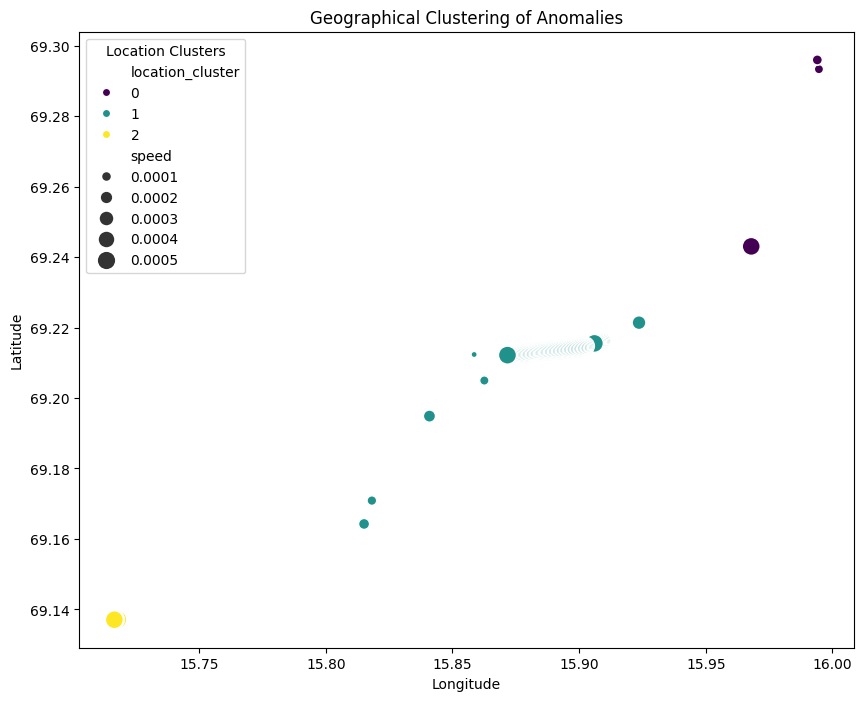

In [7]:
from sklearn.cluster import KMeans

# Use only lat and lon for clustering the anomalies
coords = anomalies[['lat', 'lon']].dropna()

# Applying KMeans clustering to anomalies
kmeans = KMeans(n_clusters=3, random_state=42).fit(coords)  # Adjust n_clusters as needed
anomalies['location_cluster'] = kmeans.labels_

# Visualizing clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=anomalies, x='lon', y='lat', hue='location_cluster', palette='viridis', size='speed', sizes=(20, 200))
plt.title("Geographical Clustering of Anomalies")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Location Clusters")
plt.show()


In [8]:
#Statistical Insights by Cluster

In [9]:
# Calculate average speed and time_diff for each cluster
cluster_stats = anomalies.groupby('location_cluster')[['speed', 'time_diff']].mean()
print("Average Speed and Time Difference by Location Cluster:")
print(cluster_stats)


Average Speed and Time Difference by Location Cluster:
                     speed  time_diff
location_cluster                     
0                 0.000158   1.833333
1                 0.000479   1.055556
2                 0.000458   1.000000


In [10]:
#Overlaying Anomalies on an Interactive Map (Using Folium)

In [11]:
import folium

# Center map around the mean coordinates of anomalies
map_center = [anomalies['lat'].mean(), anomalies['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=13)

# Add anomaly points to the map
for _, row in anomalies.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=row['speed'] / 3,  # Scale the size by speed
        color='red' if row['time_diff'] > 1 else 'blue',  # Color by time_diff threshold
        fill=True,
        fill_color='red' if row['time_diff'] > 1 else 'blue'
    ).add_to(m)

# Display the map
m.save("anomalies_map.html")
print("Map saved as anomalies_map.html")


Map saved as anomalies_map.html


In [12]:
#Temporal Analysis of Anomalies

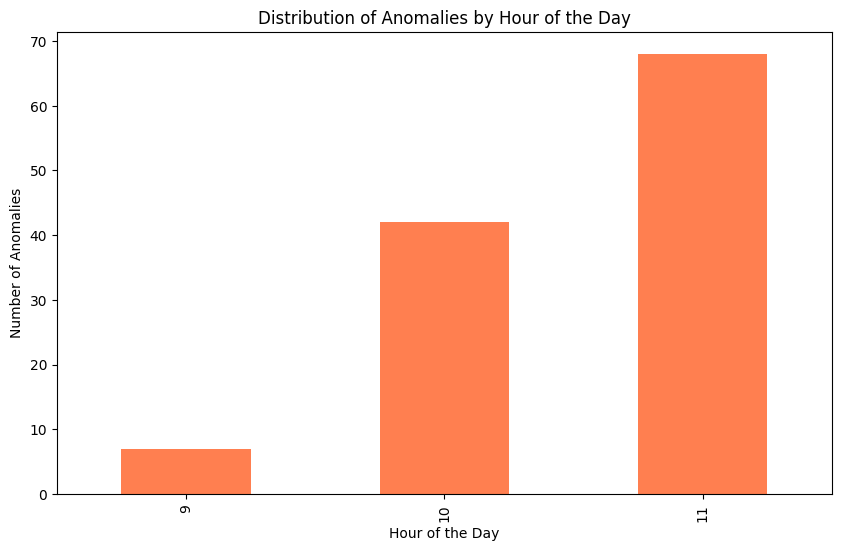

In [13]:
# Convert timestamp to datetime if it's not already
anomalies['timestamp'] = pd.to_datetime(anomalies['timestamp'])

# Extract hour and plot anomalies by hour
anomalies['hour'] = anomalies['timestamp'].dt.hour
hourly_anomalies = anomalies.groupby('hour').size()

# Plot hourly distribution of anomalies
plt.figure(figsize=(10, 6))
hourly_anomalies.plot(kind='bar', color='coral')
plt.title("Distribution of Anomalies by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Anomalies")
plt.show()


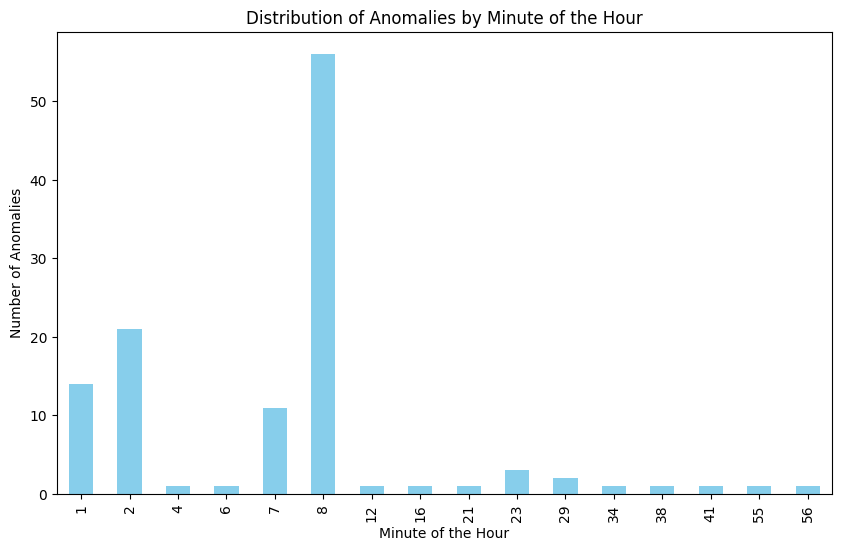

In [14]:
# Convert timestamp to datetime if it's not already
anomalies['timestamp'] = pd.to_datetime(anomalies['timestamp'])

# Extract minute and plot anomalies by minute
anomalies['minute'] = anomalies['timestamp'].dt.minute
minute_anomalies = anomalies.groupby('minute').size()

# Plot the distribution of anomalies by minute
plt.figure(figsize=(10, 6))
minute_anomalies.plot(kind='bar', color='skyblue')
plt.title("Distribution of Anomalies by Minute of the Hour")
plt.xlabel("Minute of the Hour")
plt.ylabel("Number of Anomalies")
plt.show()


In [15]:
import folium
import pandas as pd

# Load the data
data = pd.read_csv('nmea.csv')


data.columns = data.columns.str.strip()


lat_column = 'lat'  
lon_column = 'lon'  


data = data.dropna(subset=[lat_column, lon_column])


start_location = [data[lat_column].iloc[0], data[lon_column].iloc[0]]


m = folium.Map(location=start_location, zoom_start=13)


folium.Marker(
    location=start_location,
).add_to(m)

end_location = [data[lat_column].iloc[-1], data[lon_column].iloc[-1]]
folium.Marker(
    location=end_location,
    popup="End",
    icon=folium.Icon(color="red")
).add_to(m)

path = list(zip(data[lat_column], data[lon_column]))
folium.PolyLine(path, color="blue", weight=2.5, opacity=1).add_to(m)


m.save("journey_map.html")  
m  


In [16]:
import pandas as pd
from geopy.distance import geodesic

# Load the data
data = pd.read_csv('nmea.csv') 

data.columns = data.columns.str.strip()


lat_column = 'lat'  
lon_column = 'lon'  


data = data.dropna(subset=[lat_column, lon_column])


total_distance = 0.0


for i in range(1, len(data)):
  
    prev_coord = (data[lat_column].iloc[i-1], data[lon_column].iloc[i-1])
    curr_coord = (data[lat_column].iloc[i], data[lon_column].iloc[i])
    distance = geodesic(prev_coord, curr_coord).meters  
    total_distance += distance


total_distance_km = total_distance / 1000

print(f"Total distance traveled: {total_distance_km:.2f} km")


Total distance traveled: 58.86 km
